## lenet architecture with adam optimizer

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
from torch_data_augmentation import data_augment, data_loader
import os
from tqdm.notebook import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [2]:
# Hyperparameters
BATCH_SIZE = 256
IMAGE_SIZE = 128
NUM_CLASSES = 37
LEARNING_RATE = 0.001
EPOCHS = 10

## Data load and splitting

In [3]:
"""
load the dataet(PIL image and int label) and transform it to tensor image(uint8[0-255])
 and one-hot encode the labels
split val dataset into 70:30 ratio. Keep 30 to val dataset. Combine 70 into train dataset. 
"""
def one_hot_encode(x):
    return torch.nn.functional.one_hot(torch.tensor(x), num_classes=NUM_CLASSES)

# Load the dataset; transform PIL to tensor image(uint8[0-255]) and one-hot encode the labels
train_ds = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', download=False, transform=v2.ToImage(),
                    target_transform=v2.Lambda(one_hot_encode) )
temp_val_ds = torchvision.datasets.OxfordIIITPet(root='./data', split='test', download=False, transform=v2.ToImage(),
                    target_transform=v2.Lambda(one_hot_encode) )

# Define the split ratio for val_ds
part_train_size = int(0.7 * len(temp_val_ds))
val_size = len(temp_val_ds) - part_train_size

# Split the dataset into part_training and val sets
part_train_ds, val_ds = random_split(temp_val_ds, [part_train_size, val_size], generator=torch.Generator().manual_seed(42))
# Combine the part_train_ds and train_ds into a single train_ds
train_ds = ConcatDataset([train_ds, part_train_ds])

In [4]:
print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


## hypermaters

In [5]:
BATCH_SIZE = 256
IMAGE_SIZE = 128
# Set environment variables
os.environ['NUM_CLASSES'] = str(NUM_CLASSES)
os.environ['BATCH_SIZE'] = str(BATCH_SIZE)
os.environ['IMAGE_SIZE'] = str(IMAGE_SIZE)

## visualization

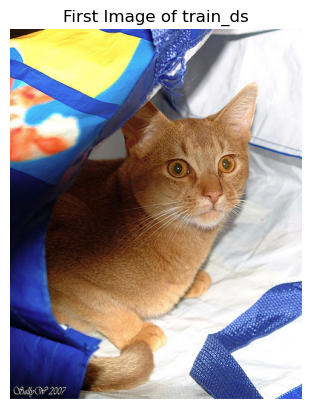

In [6]:
# Get the first image and label from the train_ds
image, label = train_ds[0]

# Convert the tensor image to numpy array
image = image.numpy()

# Transpose the image array to match the shape expected by matplotlib
image = image.transpose((1, 2, 0))

# Plot the image
plt.imshow(image)
plt.title('First Image of train_ds')
plt.axis('off')
plt.show()

In [7]:
train_ds.datasets[0].classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

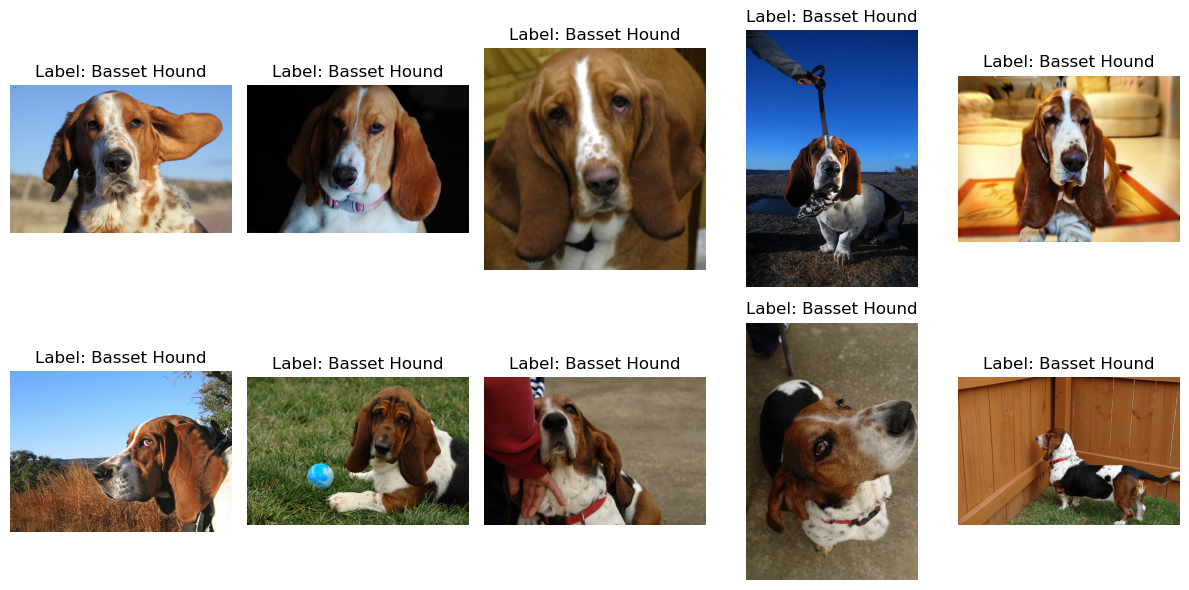

In [8]:
# Define a function to convert one-hot encoded labels to original form
def get_label_name(label):
    first_dataset = train_ds.datasets[0]
    return first_dataset.classes[torch.argmax(label).item()]

# Visualize 10 images from train_ds
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    image, label = train_ds[i+2000]
    image = image.numpy().transpose((1, 2, 0))
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].set_title(f"Label: {get_label_name(label)}")
    axs[i // 5, i % 5].axis('off')

plt.tight_layout()
plt.show()

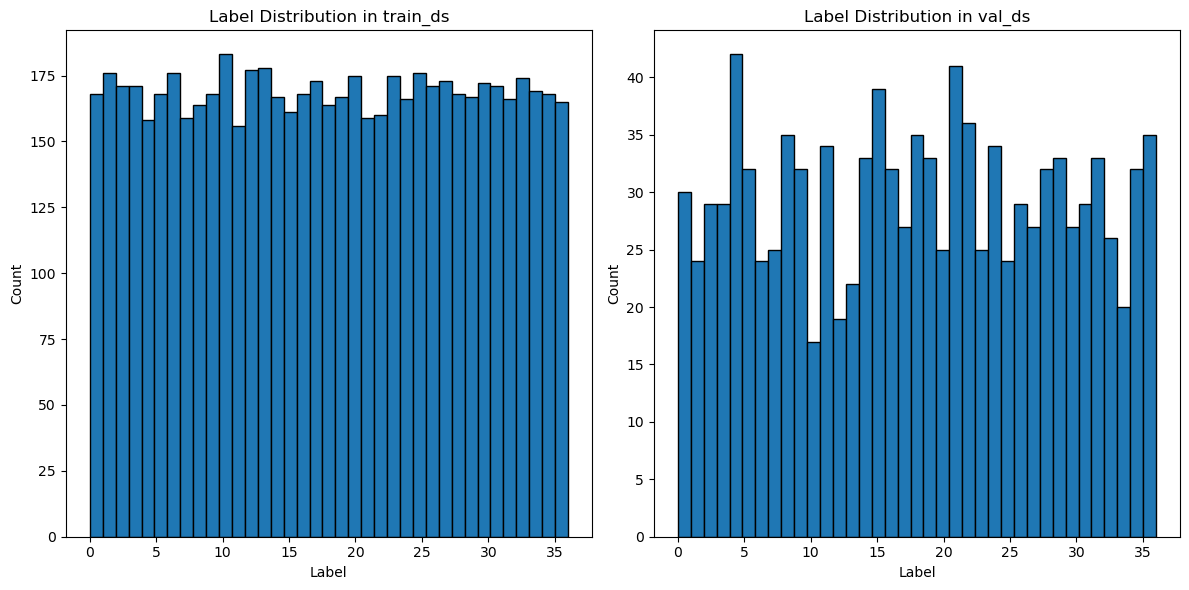

In [9]:
# Convert one-hot encoded labels to original form
train_labels = [torch.argmax(label).item() for _, label in train_ds]
val_labels = [torch.argmax(label).item() for _, label in val_ds]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for train_ds
axs[0].hist(train_labels, bins=NUM_CLASSES, edgecolor='black')
axs[0].set_title('Label Distribution in train_ds')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')

# Plot histogram for val_ds
axs[1].hist(val_labels, bins=NUM_CLASSES, edgecolor='black')
axs[1].set_title('Label Distribution in val_ds')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

## Data Augmentation

In [10]:
train_ds, val_ds = data_augment(train_ds, val_ds)

In [11]:
print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")

Number of classes: 37
Number of training samples: 37488
Number of validation samples: 1101


# 1) issue with num_worker in ipynb

In [13]:
# Create data loaders
train_loader, val_loader = data_loader(train_ds, val_ds)

# 2) very slow without num_worker

In [12]:
# Create data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print("Images:", images.shape)
    print("Labels:", labels.shape)
    print()

# 3) Use python file for num_worker - fast  

# Model

In [13]:
# Define LeNet-5 model with Batch Normalization and L2 regularization
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        # super(LeNet5, self).__init__()
        super().__init__()
        # conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode, 
        # stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        # in_channels: number of channels in the input image
        # out_channels: number of channels produced by the convolution or number of filters
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding='valid')
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding='valid')
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.l2_reg = 0.01

    def forward(self, x):
        # x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        # x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool(self.bn2(torch.relu(self.conv2(x))))
        # x.reshape(x.size(0),-1)
        x = torch.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.bn4(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [14]:
# Initialize model, loss function, and optimizer
model = LeNet5(NUM_CLASSES).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=model.l2_reg)

# Training loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(2):
    model.train()
    running_loss = 0.0
    correct = 0 #
    total = 0  #
    for images, labels in tqdm(train_loader, desc='training'):
        images = images.to('cuda', non_blocking=True)
        labels = labels.to('cuda', non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  #
        total += labels.size(0)  #
        correct += (predicted == torch.argmax(labels,1)).sum().item()  #
    train_losses.append(running_loss/len(train_loader))
    train_accs.append(100 * correct / total)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_losses[-1]}, Train Accuracy: {train_accs[-1]}%")

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to('cuda', non_blocking=True)
            labels = labels.to('cuda', non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()#*labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels,1)).sum().item()
        val_losses.append(running_loss / len(val_loader.dataset))
        val_accs.append(100 * correct / total)
    print(f"Val Loss: {train_losses[-1]}, Val Accuracy: {val_accs[-1]}%")

# Save the model
# torch.save(model.state_dict(), 'lenet5_model.pth')

training:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 3.5530184629012127, Train Accuracy: 6.316688006828852%
Val Loss: 3.5530184629012127, Val Accuracy: 14.168937329700272%


training:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 3.293509749328198, Train Accuracy: 10.723431498079385%
Val Loss: 3.293509749328198, Val Accuracy: 12.079927338782925%
